In [ ]:
# default_exp pifpafpose_detector

# detect

> Pose Detector class based on Open PifPaf and some pose modification tools

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
# These torch versions are entirely out of date, unfortunately
#%pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#%pip install openpifpaf #==0.12.14
#OpenPifPaf still tries to read PIL.PILLOW_VERSION instead of PIL.__version__ (which has been changed for a while)
#%pip install --force-reinstall "Pillow<9.0" --no-deps
#%pip install opencv-python

#!wget https://github.com/vita-epfl/openpifpaf-torchhub/releases/download/v0.11.0/shufflenetv2k30w-200510-104256-cif-caf-caf25-o10s-0b5ba06f.pkl
#!wget https://github.com/DuncanZauss/openpifpaf_assets/releases/download/v0.1.0/center_ref_shufflenetv2k30.pkl.epoch350
#!wget http://github.com/DuncanZauss/openpifpaf_assets/releases/download/v0.1.0/sk16_wholebody.pkl
#!wget http://github.com/DuncanZauss/openpifpaf_assets/releases/download/v0.1.0/sk30_wholebody.pkl

In [ ]:
#export
import torch
import openpifpaf

import cv2
import os
from matplotlib import pyplot as plt
import PIL
import io
import numpy as np

#%matplotlib inline

openpifpaf.show.Canvas.show = True
openpifpaf.show.Canvas.image_min_dpi = 200

class Detector:
    """Given a still image (or video frame), finds poses.
    
    Attributes:  
      device: PyTorch computing resource (GPU or CPU)  
      net: Pose detection neural network model  
      processor: Pose detection image processor  
    """
    
    def __init__(self):
        try:
            self.device = torch.device('cuda')  # if cuda is available
        except:
            self.device = torch.device('cpu')
            
        #self.predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k30-wholebody')
        #self.predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k30')
        self.predictor = openpifpaf.Predictor(checkpoint='resnet50')

    def detect_image(self, image_path, viz=False):
        """ Applies the pose detection model to a single image file. Returns detections. """
        pil_im = PIL.Image.open(image_path)
        image_array = np.asarray(pil_im)
        
        detections, gt_anns, image_meta = self.predictor.pil_image(pil_im)
        
        if viz:
            self.plot_poses(detections, image_array, show=True)
        
        return detections
    
    def __detect_pil_image__(self, pil_im):
        detections, gt_anns, image_meta = self.predictor.pil_image(pil_im)
        return detections
        
    
    def plot_poses(self, detections, image_array=None, show=True, savepath="", show_axis=False):

        skeleton_painter = openpifpaf.show.painters.KeypointPainter()
        # These are some of the viz parameters
        #skeleton_painter = openpifpaf.show.painters.KeypointPainter(show_box=True, marker_size=1, line_width=6, highlight_invisible=True, show_joint_scales=True)
        
        # This is the most straightforward way to draw the skeletons and annotations, but
        # it doesn't provide access to the viz parameters and doesn't allow the background
        # to be blank
        #annotation_painter = openpifpaf.show.AnnotationPainter()
        #with openpifpaf.show.image_canvas(image_array) as ax:
        #    annotation_painter.annotations(ax, detections) 

        vis_detections = []
        
        if hasattr(detections, 'data'):
            vis_detections = [detections]
        else:
            for pose in detections:
                if pose.data.shape[0] == 0:
                    continue
                vis_detections.append(pose)
                
        with openpifpaf.show.canvas() as ax:
            if image_array is not None:
                ax.imshow(image_array)
            else:
                # If there isn't a background image, the poses are plotted with the
                # origin in the bottom left, rather than top left
                ax.set_aspect('equal')
                ax.invert_yaxis()
            for detection in vis_detections:
                skeleton_painter.annotation(ax, detection)
            if not show_axis:
                ax.set_axis_off()
            fig = ax.get_figure()
            fig.set_constrained_layout(True)
            
            if savepath != "":
                fig.savefig(savepath)

        return fig
    
    def overlay_poses(self, image_array, figures_frame, show=False, source_figure='figures', show_axis=False, savepath=""):
        return self.plot_poses(figures_frame[source_figure], image_array, show=show, show_axis=show_axis, savepath=savepath)
    
    
    def detect_video(self, video_file, start_seconds=0.0, end_seconds=0.0, max_frames=0, seconds_to_skip=0.0, images_too=False, write_images=False, folder_name='video_folder'):
        """ Given a video file, extracts video frames as images at `seconds_to_skip` intervals,
            from `start_seconds` to `end_seconds`, and runs `__detect_one_or_more_images__()` on each.
            Returns a list of frame pose data items, which are dictionaries with the following elements:
            { 'frame_id': <the frame's position in this list (not in the entire video, if seconds_to_skip != 0)>, 
              'time': <the frame's timecode within the excerpt (not within the full video, if start_seconds != 0)>,
              'figures': [<OpenPifPaf pose detection objects> for all figures detected in the frame]
              <OPTIONAL> 'image': <a PIL image object for the frame>
            }
            `write_images`, if true, causes the extracted frame images to be written to a folder
            specified by `folder_name`, with the naming scheme `image00001.png`
        """
        
        GC_INTERVAL = 1000
        
        cap = cv2.VideoCapture(video_file)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print('total frames in video:',total_frames)

        video_framerate = cap.get(cv2.CAP_PROP_FPS)
        print('video FPS:',video_framerate)
        frame_duration = 1 / float(video_framerate)

        frame_count = 0.0
        frames_processed = 0
        timecode = 0.0
        skip_until = start_seconds

        pose_output = []

        if write_images:
            if not os.path.isdir(folder_name):
                os.mkdir(folder_name)
            for filename in os.listdir(folder_name):
                file_path = os.path.join(folder_name, filename)
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)

        while cap.isOpened() and (frame_count < total_frames):
            ret_val, im = cap.read()

            timecode = frame_count * frame_duration
            frame_count += 1

            if (end_seconds and timecode > end_seconds) or (max_frames and frames_processed >= max_frames):
                return pose_output

            if timecode < start_seconds:
                continue

            if im is None:
                # Might want to retry here
                # print("Missed a frame, continuing...")
                # For now, we'll count a missed frame as a processed frame
                continue

            if seconds_to_skip and timecode < skip_until:
                continue
            else:
                skip_until += seconds_to_skip

            im_height, im_width, im_channels = im.shape

            frame_id = int(round(cap.get(1)))

            # Image doesn't necessarily come in as RGB(A)!
            rgbim = cv2.cvtColor(im, cv2.COLOR_BGR2RGBA)
            pil_image = PIL.Image.fromarray(rgbim)

            detections = self.__detect_pil_image__(pil_image)

            print("Frame",frame_count,"of",total_frames,round(timecode,2),"figures",len(detections))

            this_frame_data = {'frame_id': frame_count, 'time': timecode, 'figures': detections} #, 'flipped_figures': flipped_detections, 'zeroified_figures': zeroified_detections}
            if images_too:
                this_frame_data['image'] = rgbim
            if write_images:
                savepath = os.path.join(folder_name, 'image' + str(int(frames_processed + 1)).zfill(5) + '.png')
                self.overlay_poses(im, this_frame_data, source_figure='figures', savepath=savepath)
                del im, rgbim, pil_image

            pose_output.append(this_frame_data)
            frames_processed += 1

        return pose_output

In [ ]:
import torchvision
print(dir(torchvision.models))

['AlexNet', 'DenseNet', 'Inception3', 'ResNet', 'SqueezeNet', 'VGG', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'alexnet', 'densenet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception', 'inception_v3', 'resnet', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet', 'squeezenet1_0', 'squeezenet1_1', 'vgg', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


Downloading: "http://github.com/openpifpaf/torchhub/releases/download/v0.13/resnet50-210830-150728-cocokp-slurm728641-edge513-o10s-ecd30da4.pkl" to /Users/peterbroadwell/.cache/torch/hub/checkpoints/resnet50-210830-150728-cocokp-slurm728641-edge513-o10s-ecd30da4.pkl


  0%|          | 0.00/97.4M [00:00<?, ?B/s]

/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


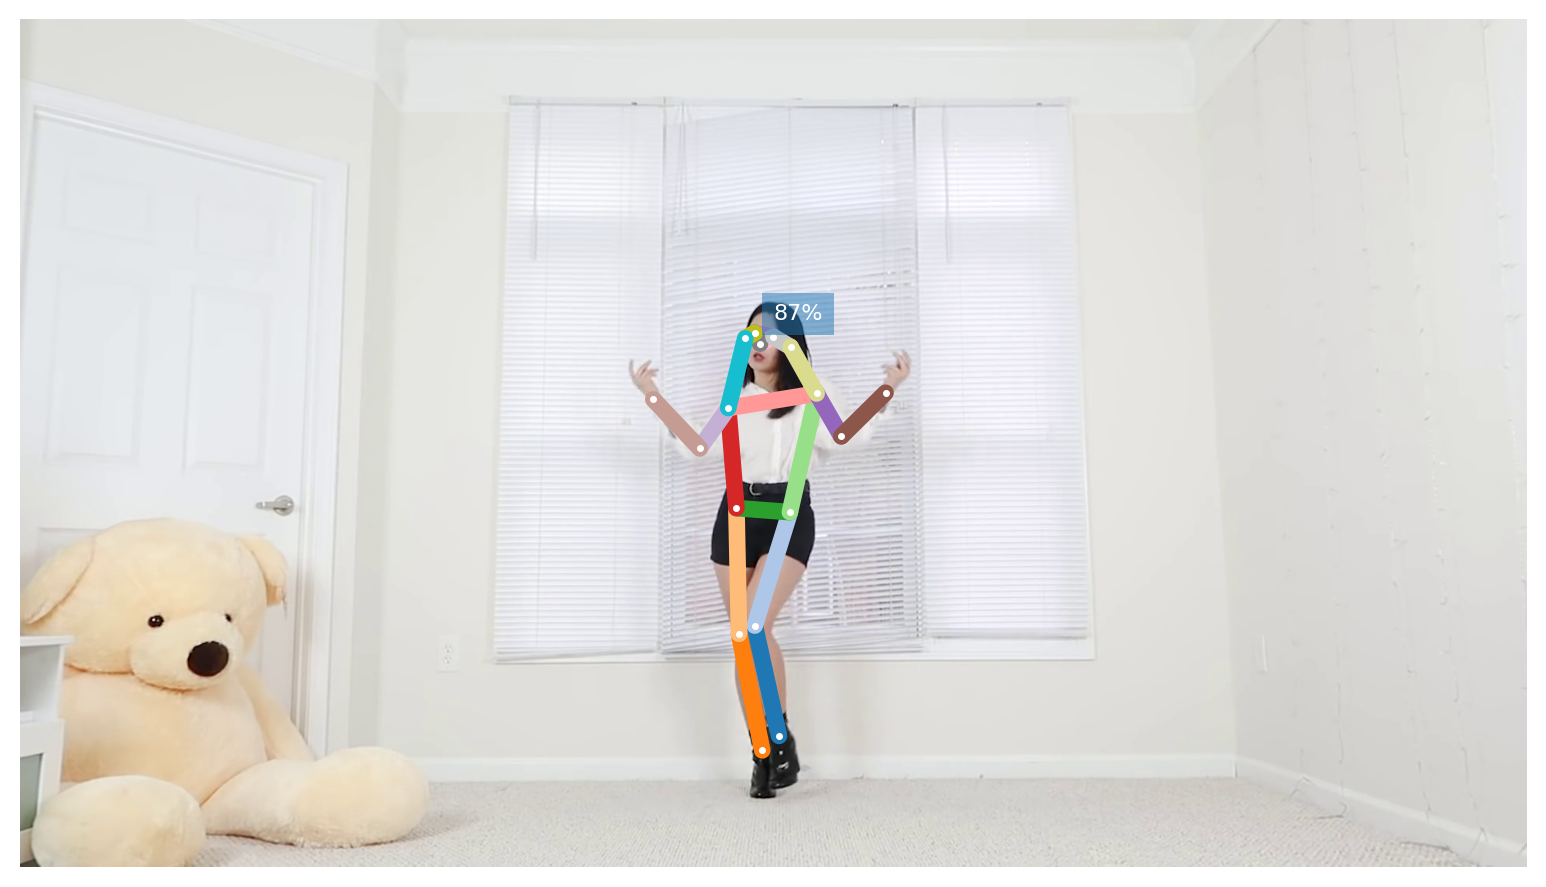

In [ ]:
teddy = Detector()
detections = teddy.detect_image('sample_data/sample1.png', viz=True)

In [ ]:
teddy = Detector()
pose_output = teddy.detect_video("/srv/choreo/Einstein.mp4", start_seconds=6310, end_seconds=7288, write_images=True, images_too=False)

In [ ]:
FPS = 25
!ffmpeg -y -framerate $FPS -pattern_type glob -i 'video_folder/*.png' -strict '-2' -c:v libx264 -vf "fps=$FPS" -pix_fmt yuv420p Einstein_ballet_pf.mp4

ffmpeg version 9c33b2f Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/broadwell/anaconda3/envs/torch --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.

In [ ]:
try:
    teddy = Detector()
    detections = teddy.detect_image('sample_data/sample1.png')
    print(detections[0])
except:
    print("Unable to instantiate a detector on your system. Do you have PyTorch with CUDA enabled?")

In [ ]:
show_doc(Detector.detect_image)
show_doc(Detector.detect_video)